
# Taxi Revenue per Zone – Linear Regression (historical)
Vorhersage und Ranking der lukrativsten Zonen basierend auf historischen Taxi- und Wetterdaten.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Load merged taxi + weather data
df = pd.read_csv("../data/taxi_weather_merged.csv")
df["pickup_hour"] = pd.to_datetime(df["pickup_hour"])
df = df.sort_values(["pickup_hour", "PULocationID"]).reset_index(drop=True)

# Build revenue target (fare + tip) per hour and zone
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])
df["log_revenue"] = np.log1p(df["revenue"])

target = "log_revenue"
print("Rows:", len(df), "Zones:", df["PULocationID"].nunique())
print("Umsatz-Median: ", df["revenue"].mean(), "$")

Rows: 309519 Zones: 246
Umsatz-Median:  72.86630252100841 $


MAE train: 50.09732073232013
MAE test : 50.526792512782166
MSE train: 11030.34152606661
MSE test : 11464.095562420234


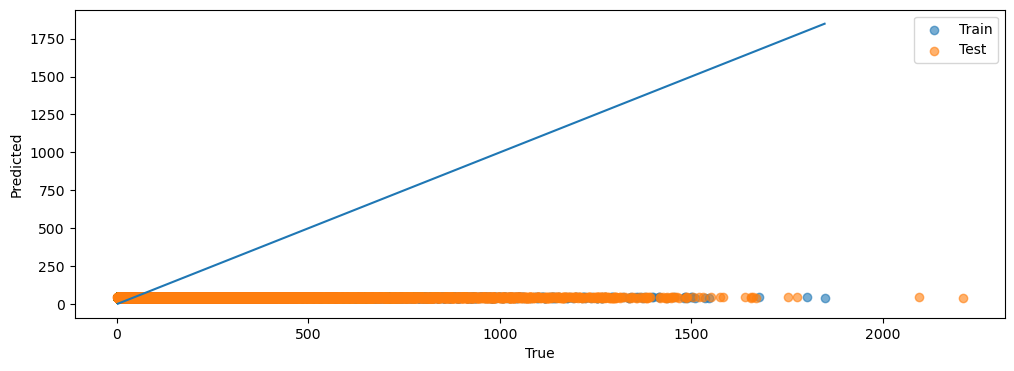

In [4]:
# Daten laden
features = ["temperature_2m (°C)", "precipitation (mm)"]

data = df[features + [target]].dropna()
X = data[features].values
y_log = data[target].values

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.7, random_state=42)


# Modell trainieren
model = LinearRegression()
model.fit(X_train, y_train_log)

y_hat_train_log = model.predict(X_train)
y_hat_test_log = model.predict(X_test)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test,  y_hat_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test,  y_hat_test)

print("MAE train:", mae_train)
print("MAE test :", mae_test)
print("MSE train:", mse_train)
print("MSE test :", mse_test)

fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()

plt.show()

In [5]:
from sklearn.metrics import r2_score

print("R2 train:", r2_score(y_train, y_hat_train))
print("R2 test :", r2_score(y_test,  y_hat_test))

# Naiver Baseline-Vergleich: immer Mittelwert vorhersagen
y_mean = np.full_like(y_test, y_train.mean())
mae_baseline = mean_absolute_error(y_test, y_mean)
print("MAE baseline:", mae_baseline)

R2 train: -0.07861883793531876
R2 test : -0.07735708707392375
MAE baseline: 56.68623146060861


# Nun mit etwas mehr features (inkl. OneHotEncoding für die Location)

**Weitere Verbesserung:**
> kein prozentueller Split der Daten mehr, sondern nacb Datum (enabled forecasting)

MAE train: 37.62347790627523
MAE test : 37.88611987634575
MSE train: 4860.720666721266
MSE test : 5000.97817685504


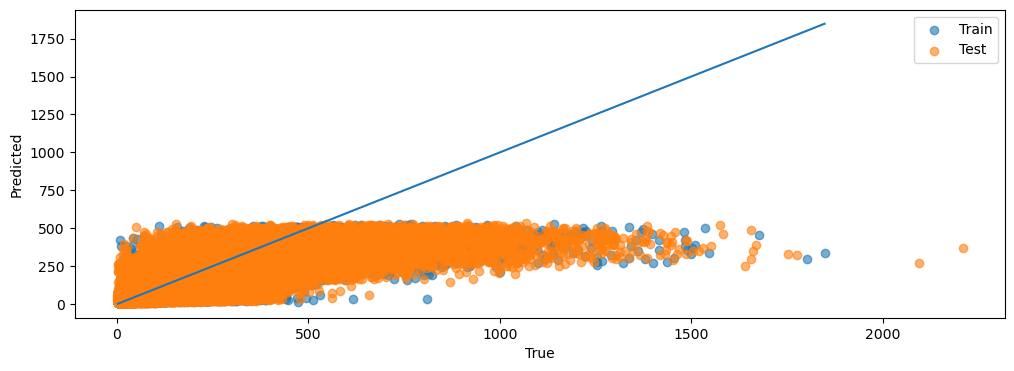

In [6]:
# Daten laden
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    # später noch OHE für PULocationID
]

cat_cols  = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target]].dropna()

X = data[features]
y_log = data[target]

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.7, random_state=42)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = LinearRegression()

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

# Modell trainieren
pipe.fit(X_train, y_train_log)

y_hat_train_log = pipe.predict(X_train)
y_hat_test_log = pipe.predict(X_test)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test,  y_hat_test)
mse_train = mean_squared_error(y_train, y_hat_train)
mse_test = mean_squared_error(y_test,  y_hat_test)

print("MAE train:", mae_train)
print("MAE test :", mae_test)
print("MSE train:", mse_train)
print("MSE test :", mse_test)

fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()

plt.show()

# Ridge & Lasso


=== OLS ===
MAE train: 37.62347790627523
MAE test : 37.88611987634575
MSE train: 4860.720666721266
MSE test : 5000.97817685504
RMSE train: 69.71886879978236
RMSE test : 70.71759453527135

=== Ridge ===
MAE train: 37.840349349931465
MAE test : 38.10994383146864
MSE train: 5025.0147019470405
MSE test : 5179.388931233243
RMSE train: 70.88733809325217
RMSE test : 71.9679715653654

=== Lasso ===
MAE train: 37.82606117526363
MAE test : 38.09385987333085
MSE train: 4917.6710866571775
MSE test : 5057.760807230559
RMSE train: 70.12610845225319
RMSE test : 71.11793590389529


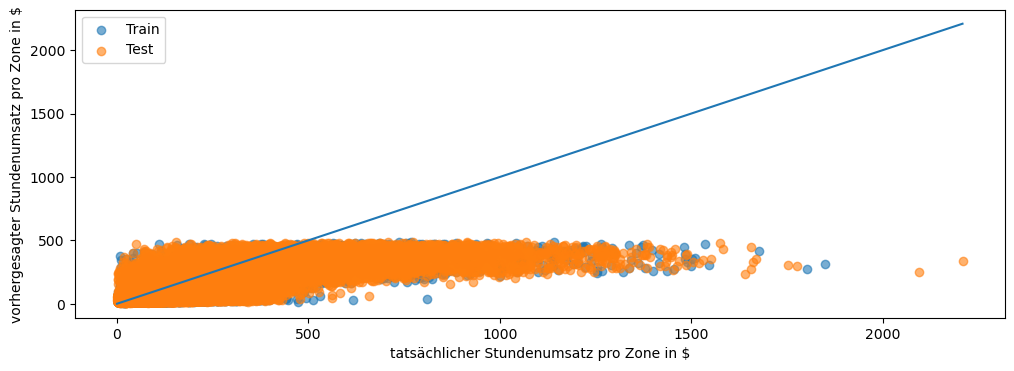

In [ ]:
# Features / Target
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
]
cat_cols = ["PULocationID"]
features = num_cols + cat_cols

# log-Target
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

data = df[features + [target]].dropna()
X = data[features]
y_log = data[target]

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.7, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

models = {
    "OLS"  : LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
}

for name, base_model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", base_model),
    ])

    # Train
    pipe.fit(X_train, y_train_log)

    # Vorhersagen im Log-Space
    y_hat_train_log = pipe.predict(X_train)
    y_hat_test_log = pipe.predict(X_test)

    # Zurück in Originalskala
    y_train = np.expm1(y_train_log.to_numpy())
    y_test = np.expm1(y_test_log.to_numpy())
    y_hat_train = np.expm1(y_hat_train_log)
    y_hat_test = np.expm1(y_hat_test_log)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test  = mean_absolute_error(y_test,  y_hat_test)
    mse_train = mean_squared_error(y_train, y_hat_train)
    mse_test  = mean_squared_error(y_test,  y_hat_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)

    print(f"\n=== {name} ===")
    print("MAE train:", mae_train)
    print("MAE test :", mae_test)
    print("MSE train:", mse_train)
    print("MSE test :", mse_test)
    print("RMSE train:", rmse_train)
    print("RMSE test :", rmse_test)


pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", Ridge(alpha=1.0)),
])
pipe.fit(X_train, y_train_log)
y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test = np.expm1(pipe.predict(X_test))
y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("tatsächlicher Stundenumsatz pro Zone in $")
ax.set_ylabel("vorhergesagter Stundenumsatz pro Zone in $")
ax.legend()
plt.show()

# Rolling


=== Ridge ===
MAE train: 38.435812528172455
MAE test : 39.82449902405341
MSE train: 8069.00207940686
MSE test : 6022.590903948796


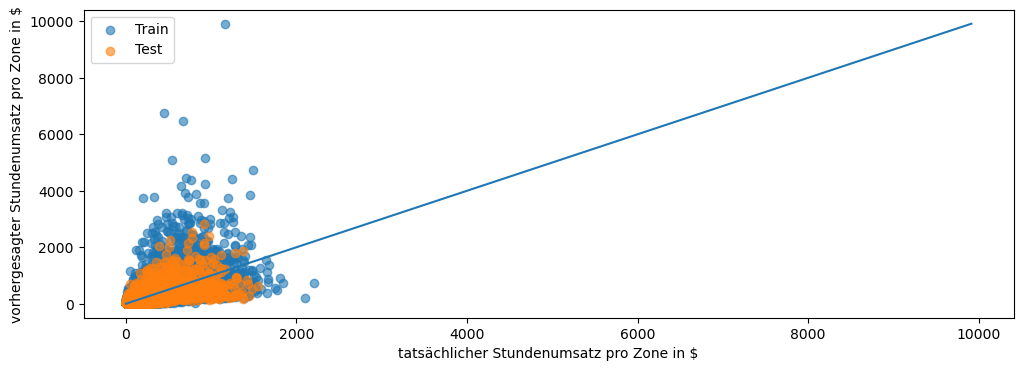

In [ ]:
# Reihenfolge: erst revenue, dann sortieren, dann Lags/Rolling
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])

df = df.sort_values(["PULocationID", "pickup_hour"])

df["revenue_lag_1"] = df.groupby("PULocationID")["revenue"].shift(1)
df["revenue_lag_24"] = df.groupby("PULocationID")["revenue"].shift(24)
df["revenue_mean_7d"] = (
    df.groupby("PULocationID")["revenue"]
      .rolling(24*7, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

# Target im Log-Space
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    "revenue_lag_1",
    "revenue_lag_24",
    "revenue_mean_7d",
]

cat_cols = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target, "pickup_hour"]].dropna()

X = data[features]
y_log = data[target]

split_date = "2023-11-01"
train = data[data["pickup_hour"] < split_date]
test  = data[data["pickup_hour"] >= split_date]

X_train = train[features]
y_train_log = train[target]
X_test  = test[features]
y_test_log  = test[target]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

model = Ridge(alpha=1.0)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", model),
])

pipe.fit(X_train, y_train_log)

y_hat_train_log = pipe.predict(X_train)
y_hat_test_log  = pipe.predict(X_test)

y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())
y_hat_train = np.expm1(y_hat_train_log)
y_hat_test = np.expm1(y_hat_test_log)


print(f"\n=== Ridge ===")
print("MAE train:", mean_absolute_error(y_train, y_hat_train))
print("MAE test :", mean_absolute_error(y_test, y_hat_test))
print("MSE train:", mean_squared_error(y_train, y_hat_train))
print("MSE test :", mean_squared_error(y_test, y_hat_test))

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", Ridge(alpha=1.0))])
pipe.fit(X_train, y_train_log)

y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test = np.expm1(pipe.predict(X_test))
y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test,  y_hat_test,  label="Test",  alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("tatsächlicher Stundenumsatz pro Zone in $")
ax.set_ylabel("vorhergesagter Stundenumsatz pro Zone in $")
ax.legend()
plt.show()

# Lags


=== OLS ===
MAE train: 38.93781081048466
MAE test : 38.97105592154072
MSE train: 8015.482595777909
MSE test : 9256.428057701367

=== Ridge ===
MAE train: 38.9916073056668
MAE test : 38.99701006340848
MSE train: 7867.909422529074
MSE test : 9045.001187160286

=== Lasso ===
MAE train: 39.4459727097505
MAE test : 39.47138941578157
MSE train: 8871.657745755852
MSE test : 10262.347756255505


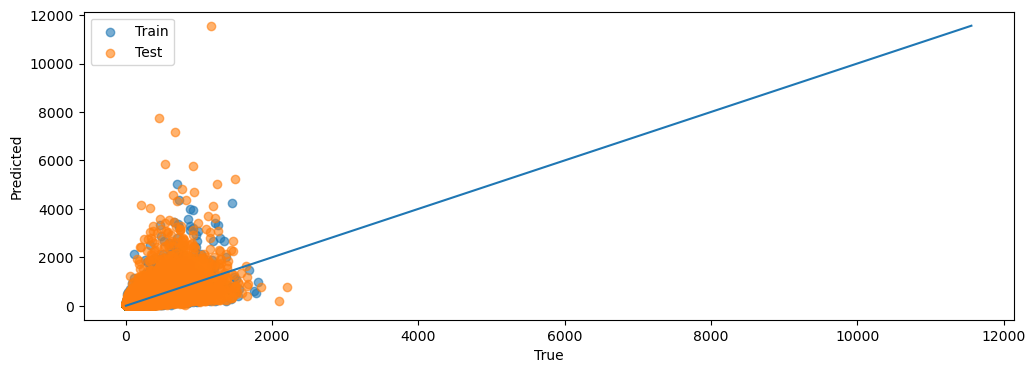

In [ ]:
# Revenue + Lags 
df["revenue"] = df["trip_count"] * (df["mean_fare"] + df["mean_tip"])

# Nach Zone und Zeit sortieren, damit Lags zeitlich korrekt sind
df = df.sort_values(["PULocationID", "pickup_hour"])

# Lag-Features pro Zone
df["revenue_lag_1"] = df.groupby("PULocationID")["revenue"].shift(1)
df["revenue_lag_24"] = df.groupby("PULocationID")["revenue"].shift(24)
df["revenue_mean_7d"] = (df.groupby("PULocationID")["revenue"].rolling(24*7, min_periods=1).mean().reset_index(level=0, drop=True))

# log-Target
df["log_revenue"] = np.log1p(df["revenue"])
target = "log_revenue"

# 1) Features / Target
num_cols = [
    "temperature_2m (°C)",
    "precipitation (mm)",
    "sunshine_duration (s)",
    "snowfall (mm)",
    "snow_depth (mm)",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    # neue Lag-Features:
    "revenue_lag_1",
    "revenue_lag_24",
    "revenue_mean_7d",
]
cat_cols = ["PULocationID"]
features = num_cols + cat_cols

data = df[features + [target]].dropna()

X = data[features]
y_log = data[target]

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.7, random_state=42
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

models = {
    "OLS"  : LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.0005, max_iter=10000),
}

for name, base_model in models.items():
    pipe = Pipeline(steps=[("preprocess", preprocess), ("model", base_model)])

    # Train
    pipe.fit(X_train, y_train_log)

    # Vorhersagen im Log-Space
    y_hat_train_log = pipe.predict(X_train)
    y_hat_test_log = pipe.predict(X_test)

    # Zurück in Originalskala
    y_train = np.expm1(y_train_log.to_numpy())
    y_test = np.expm1(y_test_log.to_numpy())
    y_hat_train = np.expm1(y_hat_train_log)
    y_hat_test = np.expm1(y_hat_test_log)

    mae_train = mean_absolute_error(y_train, y_hat_train)
    mae_test = mean_absolute_error(y_test,  y_hat_test)
    mse_train = mean_squared_error(y_train, y_hat_train)
    mse_test = mean_squared_error(y_test,  y_hat_test)

    print(f"\n=== {name} ===")
    print("MAE train:", mae_train)
    print("MAE test :", mae_test)
    print("MSE train:", mse_train)
    print("MSE test :", mse_test)

pipe = Pipeline(steps=[("preprocess", preprocess), ("model", Ridge(alpha=1.0))])
pipe.fit(X_train, y_train_log)

y_hat_train = np.expm1(pipe.predict(X_train))
y_hat_test = np.expm1(pipe.predict(X_test))
y_train = np.expm1(y_train_log.to_numpy())
y_test = np.expm1(y_test_log.to_numpy())

fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(y_train, y_hat_train, label="Train", alpha=0.6)
ax.scatter(y_test, y_hat_test, label="Test", alpha=0.6)

min_val = min(y_train.min(), y_test.min(), y_hat_train.min(), y_hat_test.min())
max_val = max(y_train.max(), y_test.max(), y_hat_train.max(), y_hat_test.max())
ax.plot([min_val, max_val], [min_val, max_val])

ax.set_xlabel("True")
ax.set_ylabel("Predicted")
ax.legend()
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.8921508793968337


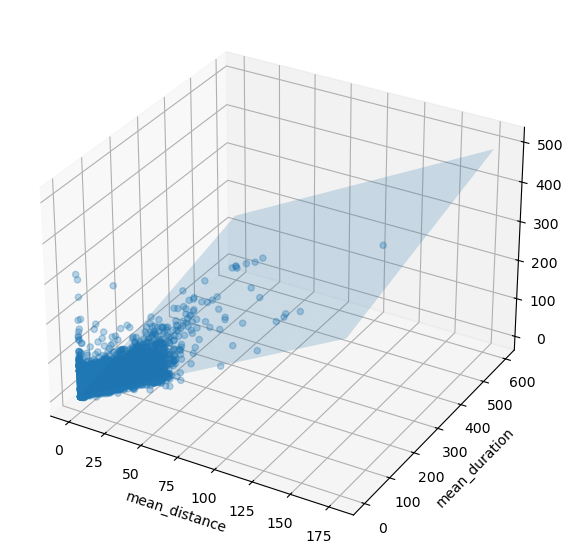

In [ ]:
X = df[["mean_distance", "mean_duration"]]
y = df["mean_fare"]

model = LinearRegression()
model.fit(X, y)

# Vorhersage auf Grid:
xx, yy = np.meshgrid(
    np.linspace(X["mean_distance"].min(), X["mean_distance"].max(), 50),
    np.linspace(X["mean_duration"].min(), X["mean_duration"].max(), 50)
)
zz = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

r2 = model.score(X, y)
print(r2)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X["mean_distance"], X["mean_duration"], y, alpha=0.3)
ax.plot_surface(xx, yy, zz, alpha=0.2)

ax.set_xlabel("mean_distance")
ax.set_ylabel("mean_duration")
ax.set_zlabel("mean_fare")
ax.zaxis.labelpad = 20 
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = df[[
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "dow_cos",
    "temperature_2m (°C)",
    "precipitation (mm)",
]].dropna()

X_vif = X_vif.assign(const=1)
for i,col in enumerate(X_vif.columns):
    print(col, variance_inflation_factor(X_vif.values, i))

hour_sin 1.0490356336688829
hour_cos 1.0896856328645037
dow_sin 1.0099109139149665
dow_cos 1.000694430799181
temperature_2m (°C) 1.0766471260323427
precipitation (mm) 1.0086597553535748
const 3.4613184647730706


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p

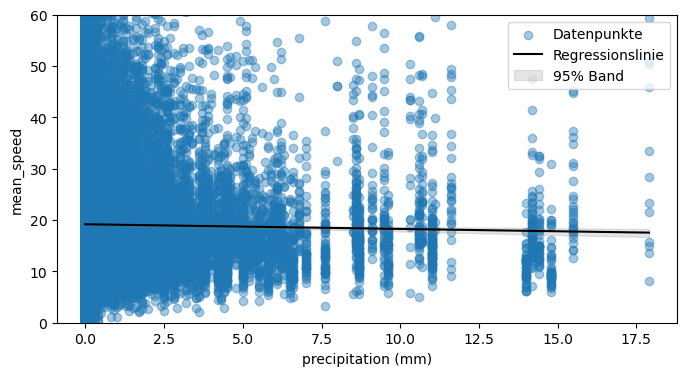

In [ ]:
# Daten auswählen und NaN entfernen
df2 = df[["precipitation (mm)", "mean_speed"]].dropna()

X = df2[["precipitation (mm)"]]
y = df2["mean_speed"]

# Modell fitten
model = LinearRegression()
model.fit(X, y)

# Linie erzeugen
x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_pred = model.predict(x_grid)

# Einfaches 95%-Konfidenzband via Bootstrapping (didaktisch, nicht perfekt)
n_boot = 200
boot_preds = []

for _ in range(n_boot):
    samp = df2.sample(len(df2), replace=True)
    m = LinearRegression()
    m.fit(samp[["precipitation (mm)"]], samp["mean_speed"])
    boot_preds.append(m.predict(x_grid))

boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds,97.5, axis=0)
# -------------------------------------------------------

# Plot
fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(X, y, alpha=0.4, label="Datenpunkte")
ax.plot(x_grid, y_pred, color="black", label="Regressionslinie")
ax.fill_between(x_grid.flatten(), lower, upper, color="gray", alpha=0.2, label="95% Band")
ax.set_ylim(0,60)
ax.set_xlabel("precipitation (mm)")
ax.set_ylabel("mean_speed")

ax.legend()
plt.show()

die Punktewolke zeigt, dass die mittlere Fahrgeschwindigkeit kaum systematisch mit Niederschlag zusammenhägt. die Regressionslinie liegt praktisch flach. Das bedeutet_ unter einer linearen Annahme ist der Effekt von Niederschlag auf die gEschwindigkeit sehr klein. Die sehr starke Streuung dominiert. Entsprechend ist der lineare Zusammenahng schwach. Das 95% Konfidenzban liegt so nahe an der Regressionlinie, dass es visuell kaum auffällt. Das passiert, wenn die geschätzte Steigung fast null ist.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/p

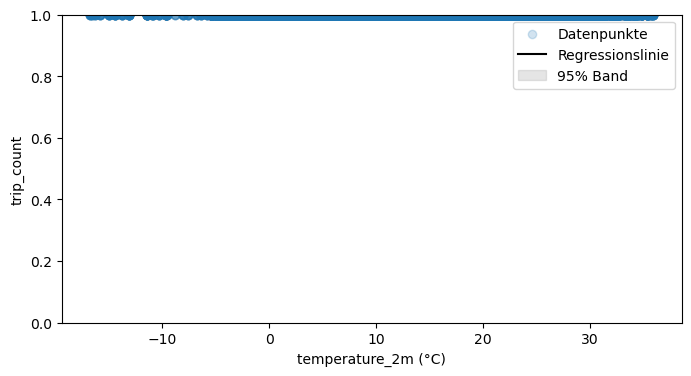

In [13]:
# benötigte Spalten selektieren
df3 = df[["temperature_2m (°C)", "trip_count"]].dropna()

X = df3[["temperature_2m (°C)"]]
y = df3["trip_count"]

# lineares Modell fitten
model = LinearRegression()
model.fit(X, y)

# x-Grid für Vorhersage
x_grid = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
y_pred = model.predict(x_grid)

# 95 %-Konfidenzband via Bootstrap (didaktisch)
n_boot = 200
boot_preds = []

for _ in range(n_boot):
    samp = df3.sample(len(df3), replace=True)
    m = LinearRegression()
    m.fit(samp[["temperature_2m (°C)"]], samp["trip_count"])
    boot_preds.append(m.predict(x_grid))

boot_preds = np.array(boot_preds)
lower = np.percentile(boot_preds, 2.5, axis=0)
upper = np.percentile(boot_preds, 97.5, axis=0)

# Plot
fig, ax = plt.subplots(figsize=(8,4))

ax.scatter(X, y, alpha=0.2, label="Datenpunkte")
ax.plot(x_grid, y_pred, color="black", label="Regressionslinie")
ax.fill_between(x_grid.flatten(), lower, upper, color="gray", alpha=0.2,
                label="95% Band")

ax.set_xlabel("temperature_2m (°C)")
ax.set_ylabel("trip_count")

# optional leicht zoomen, damit Trend sichtbar ist
ax.set_ylim(0, X.shape[0]**0)  # ggf. manuell anpassen, z.B. ax.set_ylim(0,200)

ax.legend()
plt.show()